# Clustering mediante HDBSCAN sobre soluciones MDS con matriz DTW

In [1]:
from scripts.ClusterTS_MDS import ClusterMDS

import numpy as np
from sklearn.cluster import HDBSCAN
from sklearn.metrics.cluster import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from matplotlib.pyplot import subplots, colorbar
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import rcParams
import colorcet as cc

rcParams.update({
    "text.usetex": True
})

In [2]:
PTEX_dissim = np.loadtxt("../data/PTEX_DTW_matrix.dat", dtype= np.float64, delimiter = ",")
PTEX_dissim.shape

(4616, 4616)

In [3]:
max_num_comps = 10

TEC_ClusterSeries = ClusterMDS(dissimilarity = PTEX_dissim)

In [4]:
num_comps_list = tuple(range(2, max_num_comps + 1))
min_cluster_sizes = np.arange(5, 105, 5)

number_found_clusters = [0]*len(num_comps_list)
optimal_min_cluster_sizes = [0]*len(num_comps_list)
Scores_clusters_array = np.zeros((len(num_comps_list), len(min_cluster_sizes), 4))
time_series_index_noise = []

for l, num_comps in enumerate(num_comps_list):
    TEC_ClusterSeries.ComputeMDS(num_comps_mds = num_comps, method = "SMACOF-dissim-classic", max_iter = 2000, eps = 1e-6, verbose = 0, visualize_shepard = False)
    for k, num_samples in enumerate(min_cluster_sizes):
        HDBSCAN_Out = HDBSCAN(min_cluster_size = num_samples).fit(TEC_ClusterSeries.Xc_TS)

        Scores_clusters_array[l, k, 0] = silhouette_score(TEC_ClusterSeries.Xc_TS, HDBSCAN_Out.labels_)
        Scores_clusters_array[l, k, 1] = calinski_harabasz_score(TEC_ClusterSeries.Xc_TS, HDBSCAN_Out.labels_)
        Scores_clusters_array[l, k, 2] = davies_bouldin_score(TEC_ClusterSeries.Xc_TS, HDBSCAN_Out.labels_)
        Scores_clusters_array[l, k, 3] = len(np.unique(HDBSCAN_Out.labels_))

/home/federico/.local/lib/python3.13/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 65 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/federico/.local/lib/python3.13/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 33 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/federico/.local/lib/python3.13/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 17 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/federico/.local/lib/python3.13/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/federico/.local/lib/python3.13/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid si

SMACOF-dissim-classic with 2 components has a stress-1 value of 0.108313
SMACOF-dissim-classic with 3 components has a stress-1 value of 0.063821
SMACOF-dissim-classic with 4 components has a stress-1 value of 0.049317
SMACOF-dissim-classic with 5 components has a stress-1 value of 0.042305
SMACOF-dissim-classic with 6 components has a stress-1 value of 0.038504
SMACOF-dissim-classic with 7 components has a stress-1 value of 0.036460
SMACOF-dissim-classic with 8 components has a stress-1 value of 0.035290
SMACOF-dissim-classic with 9 components has a stress-1 value of 0.034444
SMACOF-dissim-classic with 10 components has a stress-1 value of 0.033899


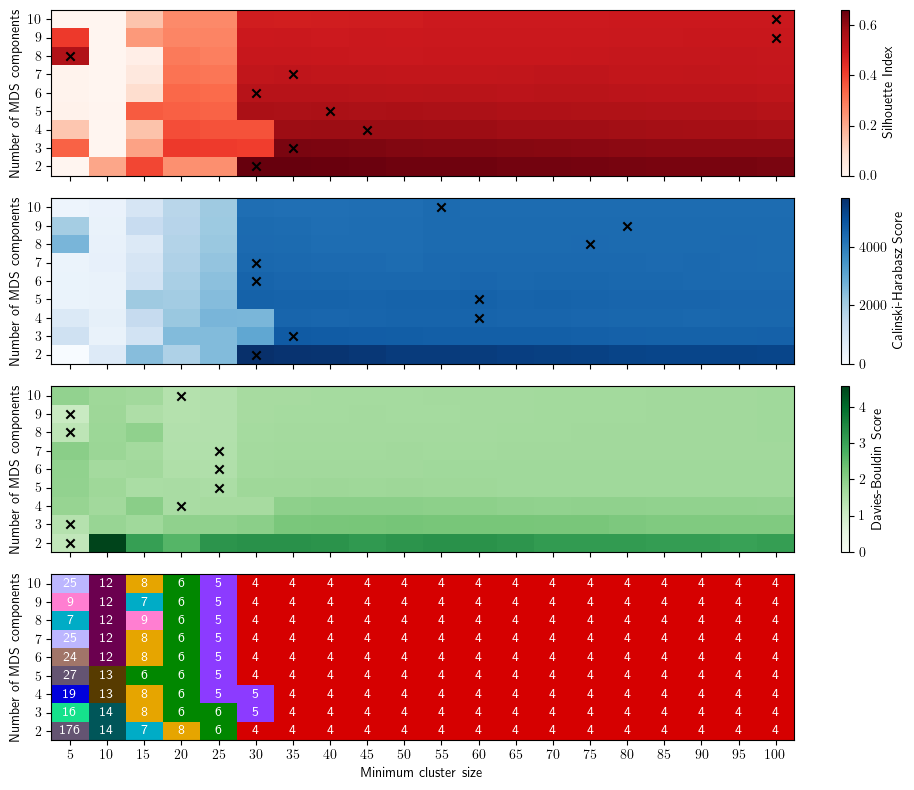

In [ ]:
Figure, Subplots = subplots(4, 1, figsize = (10, 8), sharex = True)

Labels = ["Silhouette Index", "Calinski-Harabasz Score", "Davies-Bouldin Score", "Number of clusters"]
unique_num_cluster = np.unique(Scores_clusters_array[:, :, 3])
size_unique_num_cluster = len(unique_num_cluster)
subplots_cmaps = ["Reds", "Blues", "Greens", ListedColormap(cc.glasbey_dark[:size_unique_num_cluster])]
norm_color_clusters = BoundaryNorm(boundaries=unique_num_cluster - 0.5, ncolors=size_unique_num_cluster)

for k in range(4):
    if k == 3:
        Subplots[k].pcolormesh(min_cluster_sizes, num_comps_list, Scores_clusters_array[:, :, k], cmap = subplots_cmaps[k], shading = "nearest", norm = norm_color_clusters)
    else:
        Subplots[k].pcolormesh(min_cluster_sizes, num_comps_list, Scores_clusters_array[:, :, k], cmap = subplots_cmaps[k], shading = "nearest", vmin = 0)
    Subplots[k].set_xticks(min_cluster_sizes)
    Subplots[k].set_yticks(num_comps_list)
    Subplots[k].set_ylabel("Number of MDS components")

    if k != 3:
        cbar = colorbar(Subplots[k].collections[0], ax = Subplots[k], label = Labels[k])

for i, num_comps in enumerate(num_comps_list):
    for j, min_cluster_size in enumerate(min_cluster_sizes):
        value = Scores_clusters_array[i, j, k]
        Subplots[3].text(min_cluster_size, num_comps, f"{int(value):d}",
                        ha="center", va="center", color="white", fontsize=10)
Subplots[k].set_xlabel("Minimum cluster size")

best_SI_by_comps = np.argmax(Scores_clusters_array[:, :, 0], axis = 1)
best_CH_by_comps = np.argmax(Scores_clusters_array[:, :, 1], axis = 1)
best_DB_by_comps = np.argmin(Scores_clusters_array[:, :, 2], axis = 1)

Subplots[0].scatter(min_cluster_sizes[best_SI_by_comps], num_comps_list, color = "black", marker = "x")
Subplots[1].scatter(min_cluster_sizes[best_CH_by_comps], num_comps_list, color = "black", marker = "x")
Subplots[2].scatter(min_cluster_sizes[best_DB_by_comps], num_comps_list, color = "black", marker = "x")

Figure.tight_layout()

sub0_pos = Subplots[0].get_position()
sub3_pos = Subplots[3].get_position()
Subplots[3].set_position([sub3_pos.x0, sub3_pos.y0, sub0_pos.width, sub3_pos.height])